In [1]:
%matplotlib inline
import numpy as np
from numpy.lib.stride_tricks import as_strided
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import gammaln

from itertools import permutations

import os

In [2]:
from py4j.java_gateway import JavaGateway
import subprocess
import time

import sys

In [3]:
from volatility_detector import VolatilityDetector

In [4]:
import scaw2 as SCAW2

In [5]:
outdir = '../output/experiment1'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [6]:
np.random.seed(123)

# SEED + Volatility Detector

In [7]:
delta = 0.05
blocksize = 32
epsilon_prime = 0.0075
#epsilon_prime = 0.0025
alpha = 0.6
#alpha = 0.2
decaymode = 1
compression_term = 75

mu1 = 0.2
mu2 = 0.8
length1 = 50000
#length1 = 10000
length2 = 10000
#length2 = 5000
n_repeat = 50
n_trial = 100
#seed = 123

In [8]:
class_path = './ICDMFiles_SEED_py4j/'
sys.path.insert(0, class_path)

java_file = 'SEEDChangeDetector'
class_path = '-cp ' + class_path
cmd = "java {0} {1} {2} {3} {4} {5} {6}".format(
            class_path, java_file, 
            delta, blocksize, epsilon_prime,
            alpha, compression_term)

In [9]:
cmd

'java -cp ./ICDMFiles_SEED_py4j/ SEEDChangeDetector 0.05 32 0.0075 0.6 75'

In [10]:
p = subprocess.Popen(cmd, shell=True)
time.sleep(3)
gateway = JavaGateway(start_callback_server=True)
detector_app = gateway.entry_point

In [11]:
length1 = 1000
length2 = 500
#cmd
beta = 0.01
#detector = 
r = 0.7
delta = 0.1
blocksize = 32
epsilon_prime = 0.0075
alpha = 0.6
decaymode = 1
compression_term = 75
mu1 = 0.2
mu2 = 0.8
n_repeat = 50
n_trial = 100
delays = []
seed = 13
change_points = detector_app.expr_volshift(
    mu1, mu2, length1, length2, n_repeat, seed)
change_points_npa = np.array(list(change_points))
change_points_npa_diff = np.diff(change_points_npa)

In [12]:
#lambdas_hat = np.arange(1, len(change_points_npa_diff)+1) / np.cumsum(change_points_npa_diff)
#lambdas_hat = (1 - (1-r)**np.arange(1, len(change_points_npa_diff)+1)) / \
#              (r*np.cumsum(change_points_npa_diff))
lambdas_hat = np.array(
    [(1 - (1-r)**(i+1)) / \
     np.sum( (1-r)**np.arange(i, -1, -1) * change_points_npa_diff[:i+1] ) \
     for i in range(len(change_points_npa_diff))]
)
#psc = -np.log(lambdas_hat) + lambdas_hat * change_points_npa_diff
psc = -np.log(lambdas_hat[:-1]) + lambdas_hat[:-1] * change_points_npa_diff[1:]
#change_rate_psc = np.diff(psc)/psc[:-1]
change_rate_psc = psc[1:]/psc[:-1] - 1

/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


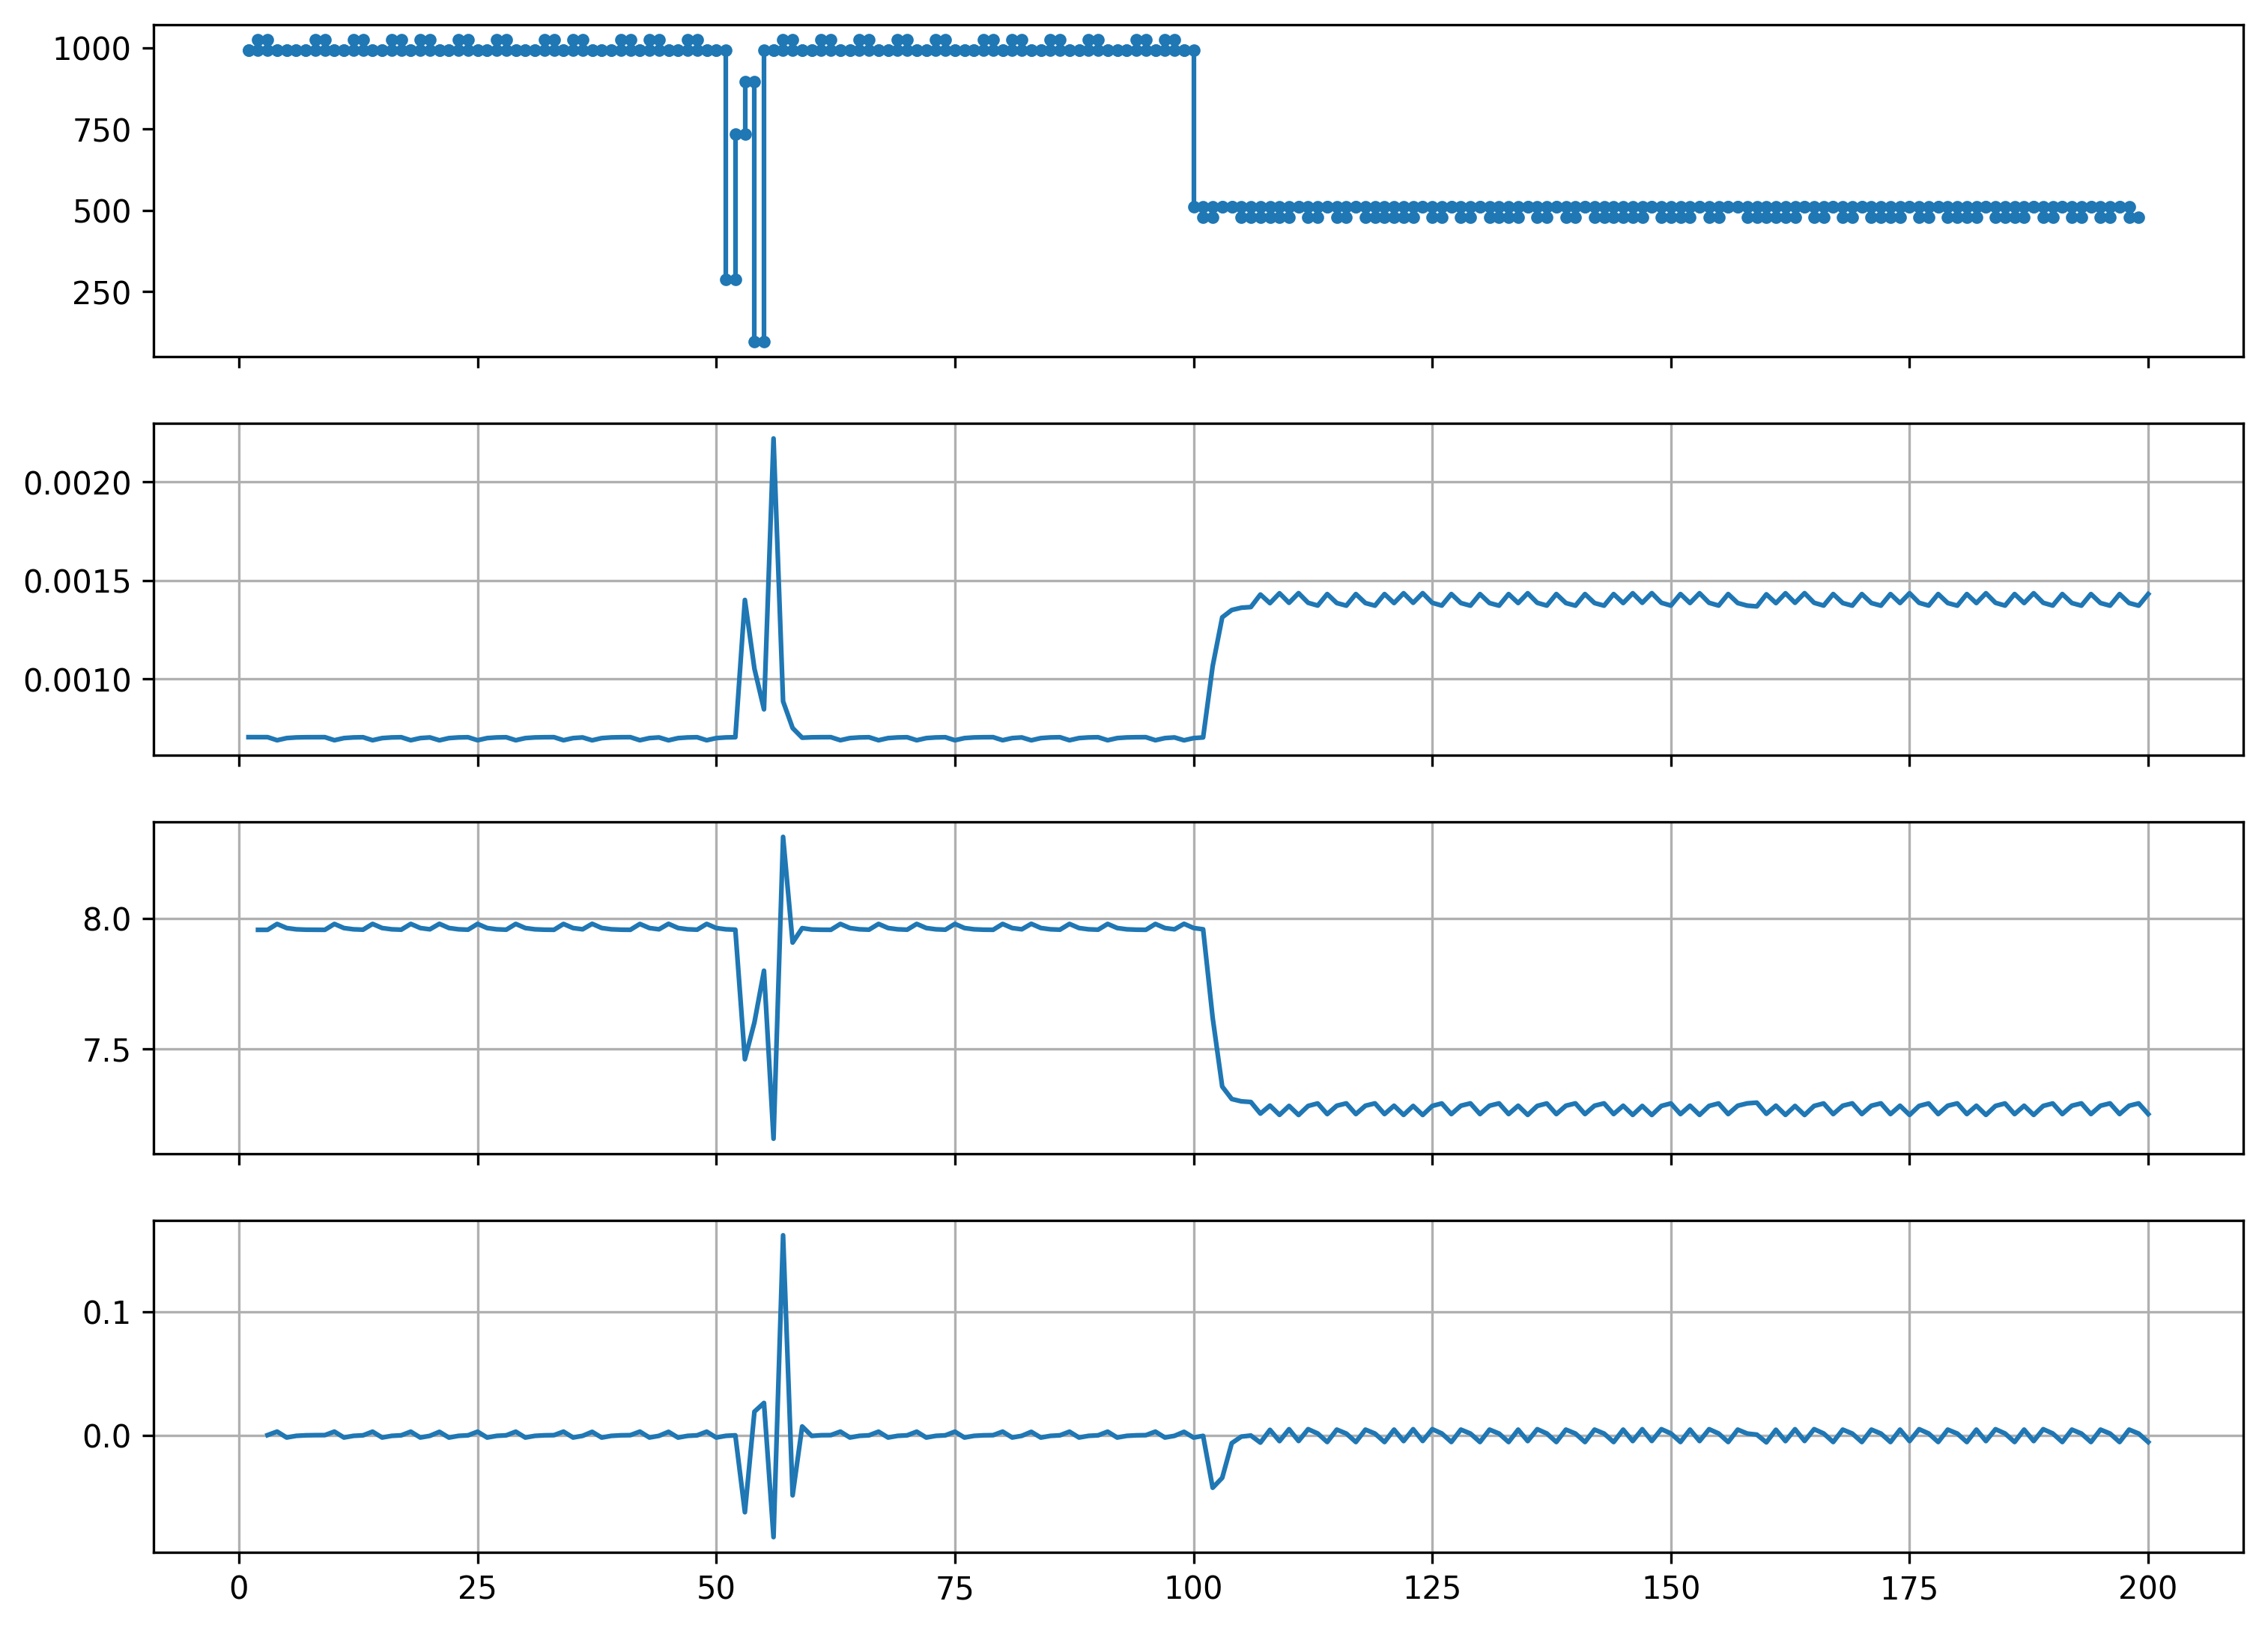

In [13]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 9), dpi=300)
axes[0].step(np.arange(1, len(change_points_npa_diff)), 
             change_points_npa_diff[1:], 
             marker='o', markersize=3)
axes[1].plot(np.arange(1, len(change_points_npa_diff)+1), lambdas_hat)
axes[1].grid()
axes[2].plot(np.arange(2, len(change_points_npa_diff)+1), psc)
axes[2].grid()
axes[3].plot(np.arange(3, len(change_points_npa_diff)+1), change_rate_psc)
axes[3].grid()
plt.show()

In [14]:
def test(length1, length2, cmd, beta, detector,
         #k=1, window=1,
         r=0.5,
         delta=0.05, blocksize=32, epsilon_prime=0.0075,
         alpha=0.6, decaymode=1, compression_term=75,
         mu1=0.2, mu2=0.8,
         n_repeat=50, n_trial=100):    
    delays = []
    for i in range(n_trial):
        seed = i
        #print('  seed=', seed)
        change_points = detector_app.expr_volshift(
            mu1, mu2, length1, length2, n_repeat, seed)
        change_points_npa = np.array(list(change_points))
        change_points_npa_diff = np.diff(change_points_npa)
        
        #lambdas_hat = np.arange(1, len(change_points_npa_diff)+1) / np.cumsum(change_points_npa_diff)
        #lambdas_hat = (1 - (1-r)**np.arange(1, len(change_points_npa_diff)+1)) / \
        #              (r*np.cumsum(change_points_npa_diff))
        lambdas_hat = np.array(
            [(1 - (1-r)**(i+1)) / \
             np.sum( (1-r)**np.arange(i, -1, -1) * change_points_npa_diff[:i+1] ) \
             for i in range(len(change_points_npa_diff))]
        )
        psc = -np.log(lambdas_hat[:-1]) + lambdas_hat[:-1] * change_points_npa_diff[1:]
        change_rate_psc = np.diff(psc)/psc[:-1]
        ok = np.logical_and(
            change_points_npa[3:] >= 2*n_repeat*length1 + length2,
            np.abs(change_rate_psc) >= beta
        )
        delay = (change_points_npa[3:][np.where(ok)[0][0]] - 2*n_repeat*length1)/length2
        delays.append(delay)
    print('{0}->{1} beta={2} mean={3} std={4}'.format(length1, length2, beta, np.array(delays).mean(), np.array(delays).std()))

In [15]:
beta = 0.01
r = 0.7

In [16]:
for (length1, length2) in permutations([100, 500, 1000, 5000, 10000, 50000, 100000], 2):
    test(length1, length2, cmd, beta, detector_app, r)

100->500 beta=0.01 mean=1.0847200000000001 std=0.008960000000000011
100->1000 beta=0.01 mean=1.03356 std=0.009920000000000009
100->5000 beta=0.01 mean=1.0066479999999998 std=0.0019475358790019969
100->10000 beta=0.01 mean=1.0037399999999999 std=0.0009329523031751721
100->50000 beta=0.01 mean=1.0007415999999998 std=0.0001908230594031642
100->100000 beta=0.01 mean=1.0149755999999999 std=0.10917361549678567
500->100 beta=0.01 mean=1.3916000000000002 std=0.15532366207374848
500->1000 beta=0.01 mean=1.0329199999999998 std=0.010063478523850497
500->5000 beta=0.01 mean=1.0067759999999997 std=0.0020177769946156253
500->10000 beta=0.01 mean=1.003708 std=0.0009541152970159626
500->50000 beta=0.01 mean=1.0271607999999999 std=0.15306399022421963
500->100000 beta=0.01 mean=1.0323099999999998 std=0.17116339197386804
1000->100 beta=0.01 mean=1.5068000000000001 std=0.18587565736265738
1000->500 beta=0.01 mean=1.07 std=0.017232527382830428
1000->5000 beta=0.01 mean=1.0078 std=0.0022170250336881496
1000

In [18]:
# 100 -> 
length1 = 100
for length2 in [500, 1000, 5000, 10000, 50000, 100000]:
    test(length1, length2, cmd, beta, detector_app, r)

100->500 beta=0.01 mean=1.0847200000000001 std=0.008960000000000011
100->1000 beta=0.01 mean=1.03356 std=0.009920000000000009
100->5000 beta=0.01 mean=1.0066479999999998 std=0.0019475358790019969
100->10000 beta=0.01 mean=1.0037399999999999 std=0.0009329523031751721
100->50000 beta=0.01 mean=1.0007415999999998 std=0.0001908230594031642
100->100000 beta=0.01 mean=1.0149755999999999 std=0.10917361549678567


In [154]:
r

0.7

In [19]:
# 500 -> 
length1 = 500
for length2 in [1000, 5000, 10000, 50000, 100000]:
    test(length1, length2, cmd, beta, detector_app, r)

500->1000 beta=0.01 mean=1.0329199999999998 std=0.010063478523850497
500->5000 beta=0.01 mean=1.0067759999999997 std=0.0020177769946156253
500->10000 beta=0.01 mean=1.003708 std=0.0009541152970159626
500->50000 beta=0.01 mean=1.0271607999999999 std=0.15306399022421963
500->100000 beta=0.01 mean=1.0323099999999998 std=0.17116339197386804


In [20]:
# 1000 -> 
length1 = 1000
for length2 in [500, 5000, 10000, 50000, 100000]:
    test(length1, length2, cmd, beta, detector_app, r)

1000->500 beta=0.01 mean=1.07 std=0.017232527382830428
1000->5000 beta=0.01 mean=1.0078 std=0.0022170250336881496
1000->10000 beta=0.01 mean=1.0031 std=0.0
1000->50000 beta=0.01 mean=1.0013687999999996 std=0.007386417978966515
1000->100000 beta=0.01 mean=1.024566 std=0.1395922198405055


In [21]:
# 5000 -> 
length1 = 5000
for length2 in [500, 1000, 10000, 50000, 100000]:
    test(length1, length2, cmd, beta, detector_app, r)

5000->500 beta=0.01 mean=1.0712800000000002 std=0.018337982440824855
5000->1000 beta=0.01 mean=1.0393199999999998 std=0.003183959798741187
5000->10000 beta=0.01 mean=1.0031 std=0.0
5000->50000 beta=0.01 mean=1.0206263999999996 std=0.14004479999999997
5000->100000 beta=0.01 mean=1.0111356 std=0.09080222085742175


In [22]:
# 10000 -> 
length1 = 10000
for length2 in [500, 1000, 5000, 50000, 100000]:
    test(length1, length2, cmd, beta, detector_app, r)

10000->500 beta=0.01 mean=1.0706400000000003 std=0.01661536638175639
10000->1000 beta=0.01 mean=1.03868 std=0.0031839597987411887
10000->5000 beta=0.01 mean=1.5715759999999996 std=3.124602058410639
10000->50000 beta=0.01 mean=1.0006263999999996 std=6.36791959748211e-05
10000->100000 beta=0.01 mean=1.0033116000000002 std=0.016616739434678514


In [23]:
# 50000 -> 
length1 = 50000
for length2 in [500, 1000, 5000, 10000, 100000]:
    test(length1, length2, cmd, beta, detector_app, r)

50000->500 beta=0.01 mean=1.07256 std=0.018203472196259715
50000->1000 beta=0.01 mean=1.039 std=0.0
50000->5000 beta=0.01 mean=1.0076079999999998 std=0.0010917582149908402
50000->10000 beta=0.01 mean=1.158524 std=1.0421026134810332
50000->100000 beta=0.01 mean=1.0040348000000001 std=0.03608059302395125


In [24]:
# 100000 -> 
length1 = 100000
for length2 in [500, 1000, 5000, 10000, 50000]:
    test(length1, length2, cmd, beta, detector_app, r)

100000->500 beta=0.01 mean=1.0712800000000002 std=0.017184923625084884
100000->1000 beta=0.01 mean=1.039 std=0.0
100000->5000 beta=0.01 mean=1.0077999999999998 std=2.220446049250313e-16
100000->10000 beta=0.01 mean=1.0031320000000001 std=0.0003183959798741055
100000->50000 beta=0.01 mean=1.1950711999999997 std=1.160075906124492


# SCAW2 + Proposed

In [26]:
def test2(length1, length2,
         r=0.5,
         mu1=0.2, mu2=0.8,
         n_repeat=50, n_trial=100):    
    np.random.seed(123)
    delays = []
    for i in range(n_trial):
        print('trial =', i)
        seed = i
        #print('  seed=', seed)
        X_list = []
        for _ in range(50):
            X_list.append(
                np.random.binomial(1, mu1, length1)
            )
            X_list.append(
                np.random.binomial(1, mu2, length1)
            )
        for _ in range(50):
            X_list.append(
                np.random.binomial(1, mu1, length2)
            )
            X_list.append(
                np.random.binomial(1, mu2, length2)
            )
        X = np.hstack(X_list)
        ins = SCAW2.MDLCPStat_adwin2(lossfunc=SCAW2.lnml_gaussian, how_to_drop = 'cutpoint')
        size_scaw2 = ins.transform(X = X, d = 1, delta = 0.9, M=5)
        change_points_npa = np.where(np.diff(size_scaw2[0, :]) < 0)[0] + 1
        change_points_npa_diff = np.diff(change_points_npa)
        
        #lambdas_hat = np.arange(1, len(change_points_npa_diff)+1) / np.cumsum(change_points_npa_diff)
        #lambdas_hat = (1 - (1-r)**np.arange(1, len(change_points_npa_diff)+1)) / \
        #              (r*np.cumsum(change_points_npa_diff))
        lambdas_hat = np.array(
            [(1 - (1-r)**(i+1)) / \
             np.sum( (1-r)**np.arange(i, -1, -1) * change_points_npa_diff[:i+1] ) \
             for i in range(len(change_points_npa_diff))]
        )
        psc = -np.log(lambdas_hat[:-1]) + lambdas_hat[:-1] * change_points_npa_diff[1:]
        change_rate_psc = np.diff(psc)/psc[:-1]
        ok = np.logical_and(
            change_points_npa[3:] >= 2*n_repeat*length1 + length2,
            np.abs(change_rate_psc) >= beta
        )
        delay = (change_points_npa[3:][np.where(ok)[0][0]] - 2*n_repeat*length1)/length2
        delays.append(delay)
    print('{0}->{1} beta={2} mean={3} std={4}'.format(length1, length2, beta, np.array(delays).mean(), np.array(delays).std()))

In [ ]:
test2(500, 1000)

trial = 0
trial = 1
trial = 2
trial = 3
trial = 4
trial = 5
trial = 6
trial = 7
trial = 8
trial = 9
trial = 10
trial = 11
trial = 12
trial = 13
trial = 14
trial = 15
trial = 16
trial = 17
trial = 18
trial = 19
trial = 20
trial = 21
trial = 22
trial = 23
trial = 24
trial = 25
trial = 26
trial = 27
trial = 28
trial = 29
trial = 30
trial = 31
trial = 32
